# Classifying High-Energy Seismic Bumps using Machine Learning

### Step 1: Import and Clean the Data

#### 1.1 Import the .arff file and convert it into a dataframe

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE


data = arff.loadarff('seismic-bumps.arff')
df = pd.DataFrame(data[0])
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


In [2]:
# fix broken string columns by decoding them to utf-8 
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.str.decode("utf-8"))

In [3]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
# Convert to CSV
# df.to_csv('seismic-bumps.csv', encoding='utf-8', index = False)

#### 1.2 Clean the data, making transformations as necessary

In [5]:
# Convert seismic intensity levels from categorical to numerical
# Note: we assign values in an increasing order so that it can represent rising intensity levels
def map_seismic_intensity(i):
    if i == 'a':
        return 0
    elif i == 'b':
        return 1
    elif i == 'c':
        return 2
    elif i == 'd':
        return 3
    
    
# Map the associated columns
df["seismic"] = df["seismic"].apply(lambda x: map_seismic_intensity(x))
df["seismoacoustic"] = df["seismoacoustic"].apply(lambda x: map_seismic_intensity(x))
df["ghazard"] = df["ghazard"].apply(lambda x: map_seismic_intensity(x))

# Convert the shift column to binary
df["shift"] = df["shift"].apply(lambda x: 1 if x == 'W' else 0)

# Fill NAs
df = df.fillna(0)

In [6]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,0,0,0,15180.0,48.0,-72.0,-72.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,14720.0,33.0,-70.0,-79.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,0,0,0,8050.0,30.0,-81.0,-78.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,28820.0,171.0,-23.0,40.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,0,0,0,12640.0,57.0,-63.0,-52.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Step 2: Exploratory Data Analysis

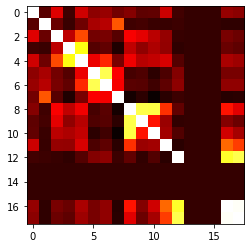

In [7]:
# Multivariate correlation analysis

plt.imshow(df.corr().fillna(0), cmap='hot', interpolation='nearest')
plt.show()


In [8]:
# A look at class distributions
df["class"].value_counts()

0    2414
1     170
Name: class, dtype: int64

As evident, there aren't many rows for the positive label. This data is highly imbalanced and can skew the results of our model.

## Step 3: Instantiating and training the Model

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.iloc[:, :17]
y = df.iloc[:, 18]

# Applying the SMOTE(Synthetic Minority Oversampling Technique) algorithm for oversampling
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 42)

Original dataset shape Counter({'0': 2414, '1': 170})
Resample dataset shape Counter({'0': 2414, '1': 2414})


In [10]:
# Instantiating a Support Vector Classifier
model = SVC()

In [11]:
model.fit(X_train, y_train)

SVC()

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

predict = model.predict(X_test) # check performance
print('ROCAUC score:',roc_auc_score(y_test, predict))
print('Accuracy score:',accuracy_score(y_test, predict))
print('F1 score:',f1_score(y_test, predict, pos_label='1'))

ROCAUC score: 0.6593971631205674
Accuracy score: 0.6618357487922706
F1 score: 0.6207430340557276
